# Projected Quasi Newton constrained FWI
We will perform FWI with total variation constraints using the following steps:
1. Prepare models
2. Setup Constraints with [SetIntersectionProjection](https://github.com/slimgroup/SetIntersectionProjection.jl)
3. Build a small local compute cluster (2 workers)
    * Take care of some HPC details related to thread affinity
4. Create source and receivers geometries
5. Build `F`, the JUDI modeling operator
6. Use `F` to create data for both models
7. Visualize data
8. Assess if data is cycle skipped at the farthest offsets
9. Build the `objective` function
10. Perform the FWI using `Projected Quasi Newton` optimization from [SlimOptim](https://github.com/slimgroup/SlimOptim.jl)
    * we compare the results of four FWI experiments
        1. unconstrained FWI
        2. FWI with bounds constraints
        3. FWI with bounds constraints and Total Variation constraints at 90% 
        4. FWI with bounds constraints and Total Variation constraints at 100%
11. Visualize velocity models and objective function
12. Visualize data match
14. Remove workers

#### Note on runtime
Warning: this notebook takes around an hour to run for 8 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

## Constrained optimization

### Conventional FWI

The usual FWI objective function is the least squares residual between observed and modeled data.

$$ \frac{1}{2} \| f(m) - d \|^2 $$

where: $m$ is the model (velocity for these examples), $d$ is the data (wavefield at the receivers), and $f$ is the nonlinear modeling operator that maps a model vector into a data vector.

### Constrained FWI

We will augment the conventional FWI objective function with *constraints on the model*, two specific examples demonstrated here are:
* *bounds constraint*: the model must remain within specified parameter bounds for minimum/maximum velocity $[v_{min},v_{max}]$
* *TV constraint*: the total variation of the model must remain below a specific threshold $\alpha$

**Parameter bound constraints**

$$
\frac{1}{2} \| f(m) - d \|^2 \quad \texttt{s.t.} \quad m \in [v_{min},v_{max}]
$$

**Total variation constraints**

$$
\frac{1}{2} \| f(m) - d \|^2 \quad \texttt{s.t.} \quad \texttt{TV}(m) \leq \alpha
$$

**Intersection of bound and total variation constraints**

$$
\frac{1}{2} \| f(m) - d \|^2 \quad \texttt{s.t.} \begin{cases}
m \in [v_{min},v_{max}] \\[5pt] 
\texttt{TV}(m) \leq \alpha
\end{cases}
$$

### Software

For these constrained optimization examples the COFII framework nonlinear operators interoperate with optimization software provided by the SLIM group led by Felix Herrmann (previously at University of British Columbia and now at Georgia Tech). 

We employ the following three packages:
- [SlimOptim](https://github.com/slimgroup/SlimOptim.jl) -- Package of optimization functions for large scale inversion. Note these SLIM constrained optimization solvers are aimed at problems where the forward evolution is expensive. This is the case for seismic modeling.

- [JOLI](https://github.com/slimgroup/JOLI.jl) -- Julia framework for constructing matrix-free linear operators 

- [SetIntersectionProjection](https://github.com/slimgroup/SetIntersectionProjection.jl) -- Julia software for computing projections onto intersections of convex and non-convex constraint sets. 
    - Peters, Bas and Herrmann, Felix J, 2019, Algorithms and software for projections onto intersections of convex and non-convex sets with applications to inverse problems. https://arxiv.org/pdf/1902.09699.pdf

You must run the previous notebook `10_add_slim_packages.ipynb` to add these packages to your environment if you have not already.

See also SLIM group examples at [ConstrainedFWIExamples](https://github.com/slimgroup/ConstrainedFWIExamples).

In [1]:
using Jets, JetPack, JetPackDSP, Distributed, LinearAlgebra, Printf, Random, JOLI, SlimOptim, SetIntersectionProjection, PyPlot

## 1. Prepare models
We apply a smoother to the true model.

In [2]:
nz,nx  = 251, 251;
dz,dx  = 15.0, 15.0;
oz,ox  = 0.0, 0.0;
extent = [0, 3750, 3750, 0]

vmin,vmax = 1500,1700;
dmin,dmax = -250,+250;

In [3]:
m0 = vmin * ones(Float32, nz, nx);
m  = vmin * ones(Float32, nz, nx);
m[101:150, 101:150] .= vmax;

In [4]:
# smoothing for the true model
ns = 5
P1 = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=true)
S1 = JopConvolve(range(P1), smoother=:rect, n=(ns,ns))
R1 = JopPad(JetSpace(Float32,nz,nx), -ns:nz+ns, -ns:nx+ns, extend=false)
mm = R1' ∘ S1 ∘ P1 * (1 ./ m)
m  = 1 ./(mm);

In [5]:
# Reshape models to be conisistent with the modeling operator
m  = reshape(m, nz, nx, 1);
m0 = reshape(m0, nz, nx, 1);

### Visualize models

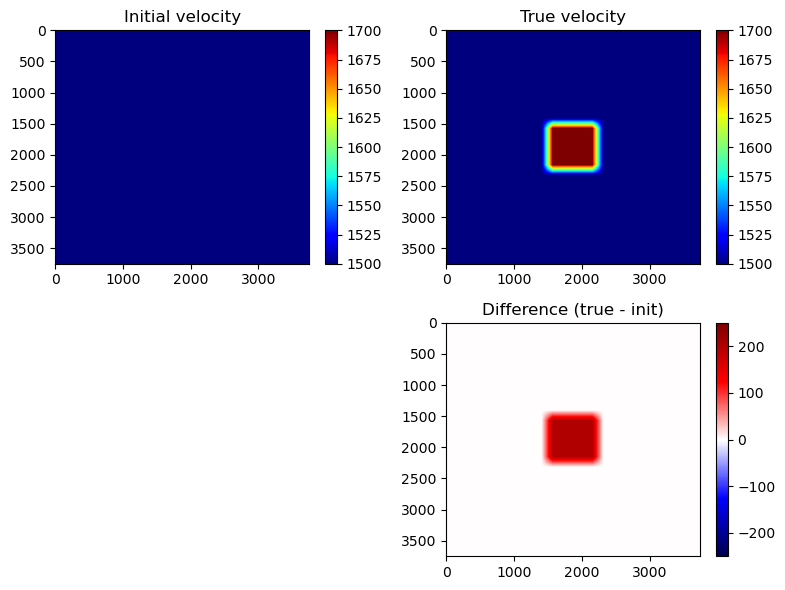

In [6]:
figure(figsize=(8,6))

subplot(2,2,1); imshow(m0,aspect="auto",cmap="jet",extent=extent); colorbar(); clim(vmin,vmax); title("Initial velocity");
subplot(2,2,2); imshow(m,aspect="auto",cmap="jet",extent=extent); colorbar(); clim(vmin,vmax); title("True velocity")
subplot(2,2,4); imshow(m.-m0,aspect="auto",cmap="seismic",extent=extent); colorbar(); clim(dmin,dmax); title("Difference (true - init)");

tight_layout()

## 2. Setup Constraints with [SetIntersectionProjection](https://github.com/slimgroup/SetIntersectionProjection.jl)

We setup two constraints, each of which is the intersection of bounds constraints -- enforcing minimum/maximum values on the model  parameters, and total variation constraints -- producing "blocky" models. 
- Bounds plus TV constraints at 90% TV norm of true model 
- Bounds plus TV constraints at 100% TV norm of true model 

In [7]:
options2 = PARSDMM_options();
options2.FL = Float32;
options2 = default_PARSDMM_options(options2,options2.FL);
options2.adjust_gamma = true
options2.adjust_rho = true
options2.adjust_feasibility_rho = true
options2.Blas_active = true
options2.maxit = 1000
options2.feas_tol = 0.001
options2.obj_tol = 0.001
options2.rho_ini=[1.0f0]
options2.evol_rel_tol = 0.00001
options2.parallel=false
options2.feasibility_only = false
options2.zero_ini_guess=true

constraint2 = Vector{SetIntersectionProjection.set_definitions}(); # bounds + TVα
options3 = PARSDMM_options();
options3.FL = Float32;
options3 = default_PARSDMM_options(options3,options3.FL);
options3.adjust_gamma = true
options3.adjust_rho = true
options3.adjust_feasibility_rho = true
options3.Blas_active = true
options3.maxit = 1000
options3.feas_tol = 0.001
options3.obj_tol = 0.001
options3.rho_ini=[1.0f0]
options3.evol_rel_tol = 0.00001
options3.parallel=false
options3.feasibility_only = false
options3.zero_ini_guess=true
constraint3 = Vector{SetIntersectionProjection.set_definitions}(); # bounds + TVβ

In [8]:
# model definition
struct grid
    n
    d
    o
end
model0 = grid((nz, nx), (dz, dx), (0., 0.))

grid((251, 251), (15.0, 15.0), (0.0, 0.0))

In [9]:
# bounds
m_min = vmin .* ones(Float32, nz, nx, 1)
m_max = vmax .* ones(Float32, nz, nx, 1)
set_type = "bounds"
TD_OP = "identity"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint2, set_definitions(set_type,TD_OP,reshape(m_min,:),reshape(m_max,:),app_mode,custom_TD_OP));
push!(constraint3, set_definitions(set_type,TD_OP,reshape(m_min,:),reshape(m_max,:),app_mode,custom_TD_OP));

In [10]:
# TVα
TVα = 0.925
(TV,dummy1,dummy2,dummy3) = get_TD_operator(model0,"TV",options2.FL)
tv2_min = 0.0
tv2_max = norm(TV*reshape(m,:),1) * TVα
set_type = "l1"
TD_OP = "TV"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint2, set_definitions(set_type,TD_OP,tv2_min,tv2_max,app_mode,custom_TD_OP));

In [11]:
# TVβ
TVβ = 1.0
(TV,dummy1,dummy2,dummy3) = get_TD_operator(model0,"TV",options3.FL)
tv3_min = 0.0
tv3_max = norm(TV*reshape(m,:),1) * TVβ
set_type = "l1"
TD_OP = "TV"
app_mode = ("matrix","")
custom_TD_OP = ([],false)
push!(constraint3, set_definitions(set_type,TD_OP,tv3_min,tv3_max,app_mode,custom_TD_OP));

In [12]:
# set up no-op projection for L2
function prj0(input)
    x = deepcopy(input)
    return reshape(x,:)
end

prj0 (generic function with 1 method)

In [13]:
# We use the `project_bounds!` methods from `SetIntersectionProjection` for the bounds constraint. 
prj1(input) = project_bounds!(input, vmin, vmax)

prj1 (generic function with 1 method)

In [14]:
# set up constraints and projection with bounds + TV
(P_sub2,TD_OP2,set_Prop2) = setup_constraints(constraint2,model0,options2.FL)
(TD_OP2,AtA2,l2,y2) = PARSDMM_precompute_distribute(TD_OP2,set_Prop2,model0,options2)
options2.rho_ini = ones(length(TD_OP2))*10.0
proj_intersection2 = x-> PARSDMM(x, AtA2, TD_OP2, set_Prop2, P_sub2, model0, options2)

# Projection function
function prj2(input)
    (x,dummy1,dummy2,dummy3) = proj_intersection2(reshape(input,:))
    return reshape(x,:)
end

prj2 (generic function with 1 method)

In [15]:
# set up constraints and projection with bounds + TV
(P_sub3,TD_OP3,set_Prop3) = setup_constraints(constraint3,model0,options3.FL)
(TD_OP3,AtA3,l3,y3) = PARSDMM_precompute_distribute(TD_OP3,set_Prop3,model0,options3)
options3.rho_ini = ones(length(TD_OP3))*10.0
proj_intersection3 = x-> PARSDMM(x, AtA3, TD_OP3, set_Prop3, P_sub3, model0, options3)

# Projection function
function prj3(input)
    (x,dummy1,dummy2,dummy3) = proj_intersection3(reshape(input,:))
    return reshape(x,:)
end

prj3 (generic function with 1 method)

## 3. Build a small local compute cluster (2 workers)

#### Setup OMP environment variables for the cluster

In the distributed compute case the workers that we add would be on different hardware, and we might add tens of workers in 2D and hundreds in 3D. Here we run on a single machine with only 2 workers, and so we need to be careful with details related to high performance computing. If we did not specify thread affinity, the two workers would compete for the same physical cores and the modeling would be *incredibly* slow.

We spin up the small 2-worker cluster by calling `addprocs(2)`, and because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"` we will see the OMP environment printed out on each worker. In that output (below) we can verify that half of the total threads (44/2 = 22) are assigned to each socket on this 2 socket system. You can obtain more details about the hardware with the shell command `lscpu`.

We set four environment variables related to OpenMP:
* `OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker
* `OMP_PROC_BIND` specifies that threads should be bound to physical cores
* `OMP_NUM_THREADS` specifies the number of threads per workers is 1/2 the number of physical cores
* `GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker

If you run the shell command `top` during execution, you will see 3 julia processes: the main process and two workers. The two workers should generally have about 50% of the system, and `load average` should tend towards the physical number of cores.

In [16]:
nthread = Sys.CPU_THREADS
nw = 2

ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread, nw))" 
addprocs(nw)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, div(nthread, nw)
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, div(nthread, nw)) = (0, 21, 22)
(place1, place2, div(nthread, nw)) = (22, 43, 22)


In [17]:
@everywhere using Distributed, DistributedArrays, DistributedJets, FFTW, Jets, JetPack, JetPackDSP, JetPackTransforms
@everywhere using LinearAlgebra, Optim, Printf, Random, WaveFD, JetPackWaveFD
@everywhere using JOLI, SlimOptim, SetIntersectionProjection

      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '22'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = '{0},{1},{2},{3},{4},{5},{6},{7},{8},{9},{10},{11},{12},{13},{14},{15},{16},{17},{18},{19},{20},{21}'
      From worker 2:	  OMP_STACKSIZE = '0'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 2:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From worker 2:	OPE

## 4. Create source and receiver geometries
- We use 8 shot locations evenly distributed across the left of the model
- We use 251 receiver locations evenly distributed across the right of the model

In [18]:
@everywhere begin
    ntrec = 1251
    dtrec = 0.004
    dtmod = 0.002
    fpeak = 5.0 
end

In [19]:
nsrc = 8
zsrc = collect(Float32, range(oz, dz * (nz -1), length=nsrc));
xsrc = Float32(dz) .* ones(Float32, nsrc);
print("zsrc; ", zsrc, "\n")
print("xsrc; ", xsrc, "\n")

zsrc; Float32[0.0, 535.7143, 1071.4286, 1607.1428, 2142.8572, 2678.5715, 3214.2856, 3750.0]
xsrc; Float32[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0]


In [20]:
nrec = 251
zrec = collect(Float32, range(oz, dz * (nz -1), length=nrec));
xrec = Float32(dz) * (nz - 2) .* ones(Float32, nrec);
print("zrec[1:10]; ", zrec[1:10], "\n")
print("xrec[1:10]; ", xrec[1:10], "\n")

zrec[1:10]; Float32[0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0]
xrec[1:10]; Float32[3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0, 3735.0]


#### Visualize geometry

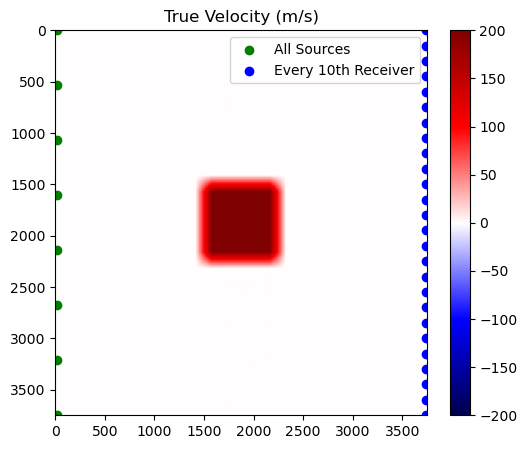

In [21]:
vmin,vmax = extrema(m)
dmin,dmax = -200,+200

figure(figsize=(6,5))
imshow(m .- m0,aspect="auto",cmap="seismic", extent=extent); 
colorbar(); clim(dmin,dmax); title("True Velocity (m/s)")
PyPlot.scatter(xsrc, zsrc, c="g", label="All Sources")
PyPlot.scatter(xrec[1:10:end], zrec[1:10:end], c="b", label="Every 10th Receiver")
legend();

## 5. Build `F`, the modeling operator

### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [22]:
@everywhere scratch = "/scratch"
@assert isdir(scratch)

@everywhere function makeF(i::Int,nz::Int,nx::Int,dz::Real,dx::Real,
        zsrc::Array{Float32},xsrc::Array{Float32},zrec::Array{Float32},xrec::Array{Float32})
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,nworkers()),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=fpeak),
        sx = xsrc[i],
        sz = zsrc[i],
        rx = xrec,
        rz = zrec,
        nbz_cache = nz,
        nbx_cache = 16,
        nsponge = 100,
        comptype = UInt32,
        srcfieldfile = joinpath(scratch, "field-$i-$(randstring()).bin"),
        reportinterval = 0)
end

In [23]:
F = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,zsrc,xsrc,zrec,xrec) for i in I[1], j in I[2]], (nsrc,1))

"Jet nonlinear operator, (251, 251, 1) → (2512008,)"

## 6. Use `F` to create the data in true and initial models

In [24]:
t1 = @elapsed begin
    d = F * m;
end
@info @sprintf("Time in true model; %.2f seconds\n", t1);

┌ Info: Time in true model; 25.90 seconds
└ @ Main In[24]:4


In [25]:
t2 = @elapsed begin
    d0 = F * m0;
end
@info @sprintf("Time in init model; %.2f seconds\n", t2);

┌ Info: Time in init model; 14.85 seconds
└ @ Main In[25]:4


#### Compute the residual data

In [26]:
r = d0 .- d;

## 7. Visualize data

In [27]:
shots = [1,4,8];

#### Plot shot gathers for true model, initial model, and residual

The table below describes the data images below. We flip the direction of the residual and modeled data in order to help display the match with the true data.

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial source 1<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True source 1<br>Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial source 1<br>Data (flipped)</b></td>
</tr>

<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial source 4<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True source 4<br>Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial source 4<br>Data (flipped)</b></td>
</tr>

<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial source 8<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True source 8<br>Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial source 8<br>Data (flipped)</b></td>
</tr>

</table>

Note that the data modeled in the initial model lacks a lot of reflectivity that is evident in the data modeled in the true model. We expect to recover this missing reflectivity with the FWI.

scale = 28.398055138268838


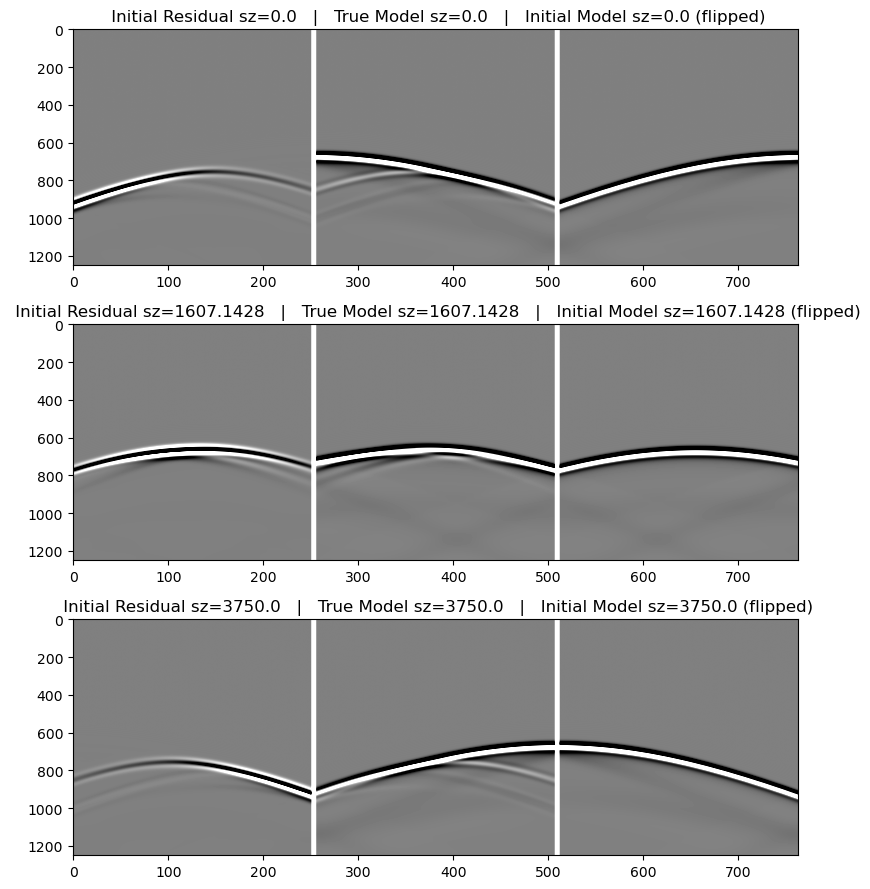

In [28]:
scale = 10.0 / sqrt(norm(d)^2 / length(d))
@show scale

nzero = 5
pad = ones(Float32,ntrec,nzero)

figure(figsize=(8,9)); clf()
for (iplot,ishot) in enumerate(shots)
    d_i  = getblock(d,ishot)
    d0_i = getblock(d0,ishot)
    r_i  = getblock(r,ishot)
    cat2 = hcat(reverse(r_i,dims=2), pad, d_i, pad, reverse(d0_i,dims=2))
    subplot(3,1,iplot);
    imshow(1.5 .* cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" Initial Residual sz=$(zsrc[ishot])   |   True Model sz=$(zsrc[ishot])   |   Initial Model sz=$(zsrc[ishot]) (flipped)");
end
tight_layout()

## 8. Assess if data is cycle skipped at the farthest offsets
Next we plot the far offset traces for these three shots in order to assess if the data is cycle skipped. 

You can ovbserve in the plots below that the refraction waveforms (first arrivals) in the initial model are not cycle skipped with respect to the true model, so we can proceed. 

A very significant part of the residual wavefield is actually reflections in this example.

size(t) = (1251,)


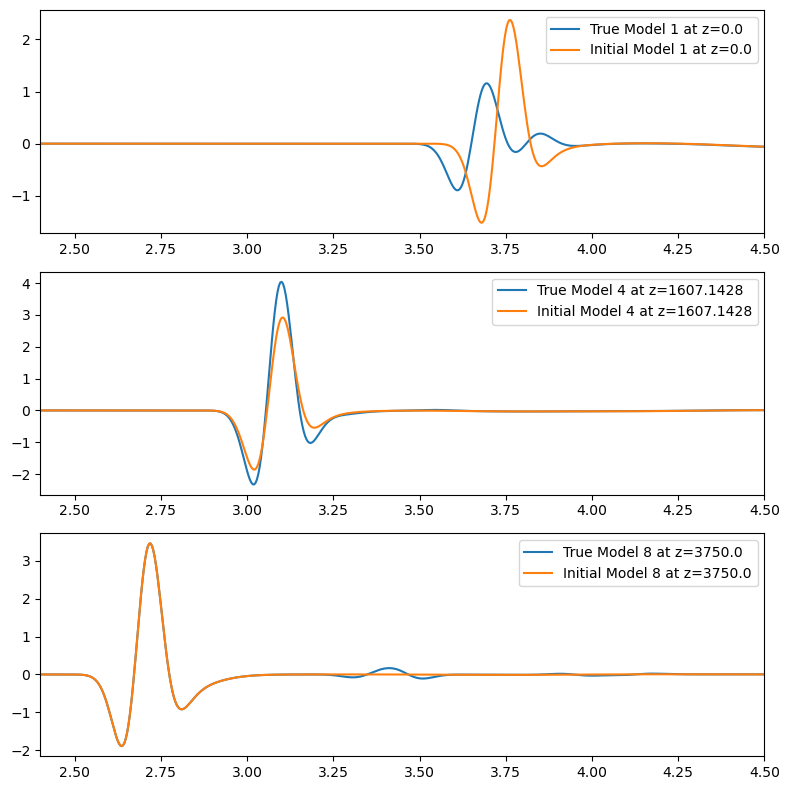

In [29]:
scale = 10.0 / sqrt(norm(d)^2 / length(d))
t = [0.0:dtrec:dtrec*(ntrec - 1);]
@show size(t)

figure(figsize=(8,8)); clf()
for (iplot,ishot) in enumerate(shots)
    subplot(3,1,iplot);
    d_i  = getblock(d,ishot)
    d0_i = getblock(d0,ishot)
    plot(t,d_i[:,end],label="True Model $(ishot) at z=$(zsrc[ishot])");
    plot(t,d0_i[:,end],label="Initial Model $(ishot) at z=$(zsrc[ishot])");
    xlim([2.4,4.5])
    legend()
end
tight_layout()

## 9. Build the `objective` function

#### Build src/rec positions mask
We use this mask to remove the imprint in gradients of proximity to source locations. The mask is set to 0 wherever a source or receiver is close, and is set to 1 otherwise. Without this mask most of the gradient updates would be concentrated close to sources where the model is correct. 

In [30]:
wb_mask = ones(Float32,size(m))
# wb_mask[:, 1:1+5] .= 0;
# wb_mask[:, end-5:end] .= 0;

# figure(figsize=(6,5))
# imshow(wb_mask[:,:,1], aspect="auto",cmap="gray_r",clim=[0,1.5],extent=extent);
# colorbar();
# title("Water Bottom Mask");
# tight_layout()

#### Build the `objective` function
This method is called by the solver whenever the gradient is required. Steps in computing the gradient are as follows:
1. Apply the adjoint of the Jacobian to the current residual `J' * [F*v - d]` 
1. Apply simple scaling based on the size of the first gradient, and save to apply to future gradients

In [31]:
@everywhere α = 0.5

global gscale = 0f0
global fcalls = 0
global gcalls = 0

function objective(F, _G, _m, d, wb_mask)
    m = reshape(_m, domain(F))
    J = jacobian(F,m)

    # illumination compensation
    s1 = srcillum(J)
    srms = sqrt(norm(s1)^2 / length(s1))
    s2 = s1 .+ eps(Float32) * srms
    s3 = s2.^(-α)
    s3 ./= maximum(s3)
    R  = JopDiagonal(reshape(s3, domain(F)))

    # modeling
    dm = zeros(range(F))
    t = @elapsed begin
        dm .= F * m
        global fcalls += 1
    end

    # gradient
    if _G != nothing
        G = reshape(_G, domain(F))
        G .= R ∘ J' * (dm .- d)
        G .*= wb_mask

        global gscale
        if gscale == 0.0
            # compute scalar from first gradient, apply to future gradients
            gscale = 100 ./ maximum(G) 
            @show gscale
        end
        G .*= gscale
        global gcalls += 1
    end

    ϕ = Float32(0.5 * norm(dm .- d)^2)
    
    return ϕ
end

# struct to save the first gradient scalar
global gscale = 0f0
f(x) = objective(F, nothing, x, d, wb_mask);
g!(G, x) = objective(F, G, x, d, wb_mask);
fg!(G, x) = objective(F, G, x, d, wb_mask);

#### Compute gradient

In [32]:
g1 = zeros(domain(F))
tg1 = @elapsed begin
    g!(g1, reshape(m0,:))
    gscale = 0
end
@show tg1;

gscale = 2817.6455f0
tg1 = 17.49334668


#### Visualize gradient

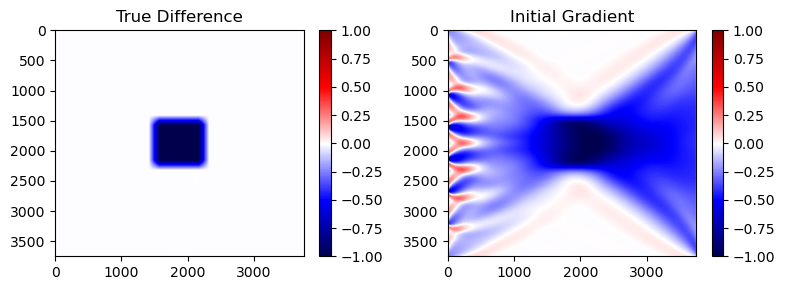

extrema(g1) = (-292.0481f0, 100.0f0)


In [33]:
dm = reshape(m0 .- m,nz,nx)
g1 = reshape(g1,nz,nx)

@show extrema(g1)

figure(figsize=(8,3))

subplot(1,2,1)
imshow(reshape(dm,nz,nx) ./ maximum(abs,dm),aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(-1,1);
title("True Difference");

subplot(1,2,2)
imshow(reshape(g1,nz,nx) ./ maximum(abs,g1),aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(-1,1);
title("Initial Gradient");

tight_layout()

## 10. Perform the FWI using `Projected Quasi Newton` optimization
We will do 10 functions evaluation cost of projected quasi-Newton with four inversion tests:
- Unconstrained
- Bound constraints only
- Bound + TV α constraints
- Bound + TV β constraints

In [34]:
# FWI with PQN
niter = 20
options_pqn = pqn_options(progTol=0, store_trace=true, verbose=1, maxIter=niter)

SlimOptim.PQN_params(1, 1.0f-5, 0, 20, 0.0001f0, 10, false, true, true, 1.0f-6, 1.0f-7, 100, false, 20, 1, 1)

In [35]:
# FWI with PQN -- unconstrained
gscale = 0f0
fcalls = 0
gcalls = 0
mf0  = deepcopy(m0)
sol0 = pqn(f, g!, fg!, reshape(mf0,:), prj0, options_pqn);
mf0  = reshape(prj0(sol0.x),nz,nx)   # optimal solution
ϕ_0  = sol0.ϕ_trace;                 # cost vs iteration
m_0  = sol0.x_trace;                 # model vs iteration

Running PQN...
Number of L-BFGS Corrections to store: 10
Spectral initialization of SPG: 1
Maximum number of SPG iterations: 100
SPG optimality tolerance: 1.00e-06
SPG progress tolerance: 1.00e-07
PQN optimality tolerance: 1.00e-05
PQN progress tolerance: 0.00e+00
Quadratic initialization of line search: 0
Maximum number of iterations: 20
Line search: BackTracking{Float32, Int64}
gscale = 2817.6455f0
 Iteration   FunEvals  GradEvals Projections     Step Length    Function Val        Opt Cond
         0          0          0          0     0.00000e+00     1.02521e+05     2.92048e+02
         1          4          2          6     2.11159e-01     4.02209e+04     2.06668e+02
         2          5          3        210     1.00000e+00     1.36581e+04     1.26146e+02
         3          6          4        414     1.00000e+00     4.80837e+03     6.14696e+01
         4          7          5        618     1.00000e+00     2.34948e+03     3.58324e+01
         5          8          6        822

In [36]:
mrms = sqrt(norm(mf0 .- reshape(m,nz,nx))^2 / length(m))
@printf("fcalls,gcalls,mrms; %5d %5d %.2f\n", fcalls, gcalls, mrms)

fcalls,gcalls,mrms;    43    21 24.93


In [37]:
# FWI with PQN -- bound constrained
gscale = 0f0
fcalls = 0
gcalls = 0
mf1  = deepcopy(m0)
sol1 = pqn(f, g!, fg!, reshape(mf1,:), prj1, options_pqn);
mf1  = reshape(prj1(sol1.x),nz,nx)   # optimal solution
ϕ_1  = sol1.ϕ_trace;                 # cost vs iteration
m_1  = sol1.x_trace;                 # model vs iteration

Running PQN...
Number of L-BFGS Corrections to store: 10
Spectral initialization of SPG: 1
Maximum number of SPG iterations: 100
SPG optimality tolerance: 1.00e-06
SPG progress tolerance: 1.00e-07
PQN optimality tolerance: 1.00e-05
PQN progress tolerance: 0.00e+00
Quadratic initialization of line search: 0
Maximum number of iterations: 20
Line search: BackTracking{Float32, Int64}
gscale = 2817.6455f0
 Iteration   FunEvals  GradEvals Projections     Step Length    Function Val        Opt Cond
         0          0          0          0     0.00000e+00     1.02521e+05     2.00001e+02
         1          4          2          6     2.11128e-01     4.43986e+04     1.36054e+02
         2          5          3        210     1.00000e+00     2.38057e+04     1.49433e+02
         3          6          4        414     1.00000e+00     1.06408e+04     9.23970e+01
         4          7          5        618     1.00000e+00     4.60928e+03     5.33060e+01
         5          8          6        822

In [38]:
mrms = sqrt(norm(mf1 .- reshape(m,nz,nx))^2 / length(m))
@printf("fcalls,gcalls,mrms; %5d %5d %.2f\n", fcalls, gcalls, mrms)

fcalls,gcalls,mrms;    43    21 6.48


In [39]:
# FWI with PQN -- bound constrained + TVα
gscale = 0f0
fcalls = 0
gcalls = 0
mf2  = deepcopy(m0)
sol2 = pqn(f, g!, fg!, reshape(mf2,:), prj2, options_pqn);
mf2  = reshape(prj2(sol2.x),nz,nx)  # optimal solution
ϕ_2  = sol2.ϕ_trace;                # cost vs iteration
m_2  = sol2.x_trace;                # model vs iteration

Running PQN...
Number of L-BFGS Corrections to store: 10
Spectral initialization of SPG: 1
Maximum number of SPG iterations: 100
SPG optimality tolerance: 1.00e-06
SPG progress tolerance: 1.00e-07
PQN optimality tolerance: 1.00e-05
PQN progress tolerance: 0.00e+00
Quadratic initialization of line search: 0
Maximum number of iterations: 20
Line search: BackTracking{Float32, Int64}
input to PARSDMM is feasible, returning
gscale = 2817.6455f0
 Iteration   FunEvals  GradEvals Projections     Step Length    Function Val        Opt Cond
relative evolution to small, exiting PARSDMM (iteration 209)
         0          0          0          0     0.00000e+00     1.02521e+05     1.30990e+02
relative evolution to small, exiting PARSDMM (iteration 209)
relative evolution to small, exiting PARSDMM (iteration 209)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 138)
         1          4          2          6     2.11005e-01     6.55231e+04     1.15805

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
         2          5          3         30     1.00000e+00     2.72512e+04     1.44463e+02
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 18)
relative

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 43)
         3          6          4         52     1.00000e+00     8.38986e+03     6.34877e+01
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)


┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 37)
relative evolution to small, exiting PARSDMM (iteration 18)
stationary objective and reached feasibility, exiting PARSDMM (iteration 40)
         4          7          5         64     1.00000e+00     5.04153e+03     4.56531e+01
relative evolution to small, exiting PARSDMM (iteration 43)
relative evolution to small, exiting PARSDMM (iteration 53)
relative evolution to small, exiting PARSDMM (iteration 59)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 42)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 37)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 36)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 34)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 37)
input to PARSDMM is feasible, r

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
         6          9          7        284     1.00000e+00     1.55031e+03     2.71655e+01
relative evolution to small, exiting PARSDMM (iteration 20)
stationary objective and reached feasibility, exiting PARSDMM (iteration 60)
relative evolution to small, exiting PARSDMM (iteration 64)
relative evolution to small, exiting PARSDMM (iteration 39)
relative evolution to small, exiting PARSDMM (iteration 28)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 30)
input to PARSDMM is feasible, returning
stationary objective and reached feasibility, exiting PARSDMM (iteration 31)
relative evolution to small, exiting PARSDMM (iteration 31)
input to PARSDMM is feasible, returning
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
input to PARSDMM 

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
         8         11          9        506     1.00000e+00     6.76006e+02     1.75726e+01
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 41)
relative evolution to small, exiting PARSDMM (iteration 50)
relative evolution to small, exiting PARSDMM (iteration 36)
relative evolution to small, exiting PARSDMM (iteration 28)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 41)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 16)
relative ev

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
         9         12         10        528     1.00000e+00     4.85814e+02     1.29839e+01
stationary objective and reached feasibility, exiting PARSDMM (iteration 32)
relative evolution to small, exiting PARSDMM (iteration 71)
relative evolution to small, exiting PARSDMM (iteration 112)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 35)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evol

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 17)
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
        10         13         11        548     1.00000e+00     3.28341e+02     1.05518e+01
relative evolution to small, exiting PARSDMM (iteration 36)
no primal residual reduction, fixing PARSDMM rho & gamma (iteration 64)
relative evolution to small, exiting PARSDMM (iteration 137)
relative evolution to small, exiting PARSDMM (iteration 104)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 36)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 37)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 36)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 42)
input to PARSDMM 

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)


┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
stationary objective and reached feasibility, exiting PARSDMM (iteration 31)
relative evolution to small, exiting PARSDMM (iteration 16)


In [40]:
mrms = sqrt(norm(mf2 .- reshape(m,nz,nx))^2 / length(m))
@printf("fcalls,gcalls,mrms; %5d %5d %.2f\n", fcalls, gcalls, mrms)

fcalls,gcalls,mrms;    45    12 11.74


In [41]:
# FWI with PQN -- bound constrained + TVβ
gscale = 0f0
fcalls = 0
gcalls = 0
mf3  = deepcopy(m0)
sol3 = pqn(f, g!, fg!, reshape(mf3,:), prj3, options_pqn);
mf3  = reshape(prj2(sol3.x),nz,nx)  # optimal solution
ϕ_3  = sol3.ϕ_trace;                # cost vs iteration
m_3  = sol3.x_trace;                # model vs iteration

Running PQN...
Number of L-BFGS Corrections to store: 10
Spectral initialization of SPG: 1
Maximum number of SPG iterations: 100
SPG optimality tolerance: 1.00e-06
SPG progress tolerance: 1.00e-07
PQN optimality tolerance: 1.00e-05
PQN progress tolerance: 0.00e+00
Quadratic initialization of line search: 0
Maximum number of iterations: 20
Line search: BackTracking{Float32, Int64}
input to PARSDMM is feasible, returning
gscale = 2817.6455f0
 Iteration   FunEvals  GradEvals Projections     Step Length    Function Val        Opt Cond
relative evolution to small, exiting PARSDMM (iteration 209)
         0          0          0          0     0.00000e+00     1.02521e+05     1.36864e+02
relative evolution to small, exiting PARSDMM (iteration 209)
relative evolution to small, exiting PARSDMM (iteration 209)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 19)
         1          4          2          6     2.11013e-01     6.36682e+04     1.74482e

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 42)
         3          6          4        226     1.00000e+00     8.30036e+03     6.58434e+01
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 68)
relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)


┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 37)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 38)
         4          7          5        240     1.00000e+00     4.83349e+03     4.33645e+01
relative evolution to small, exiting PARSDMM (iteration 39)
relative evolution to small, exiting PARSDMM (iteration 45)
relative evolution to small, exiting PARSDMM (iteration 55)
input to PARSDMM is feasible, returning
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
input to PARSDMM is feasible, returning
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
input to PARSDMM is feasible, returning
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
relative evolution to small, exiting PARSDMM (iteration 30)
input to PARSDMM is feasible, returning
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
relative evolution to small, exiting PAR

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 35)
         6          9          7        460     1.00000e+00     1.53420e+03     2.63990e+01
relative evolution to small, exiting PARSDMM (iteration 20)
stationary objective and reached feasibility, exiting PARSDMM (iteration 40)
relative evolution to small, exiting PARSDMM (iteration 65)
relative evolution to small, exiting PARSDMM (iteration 34)
stationary objective and reached feasibility, exiting PARSDMM (iteration 23)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 26)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 29)
relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 31)
relative evolution to small, exiting PARSDMM (iteration 18)
stationary obj

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 20)
         7         10          8        482     1.00000e+00     1.00324e+03     2.62830e+01
relative evolution to small, exiting PARSDMM (iteration 19)
relative evolution to small, exiting PARSDMM (iteration 70)
relative evolution to small, exiting PARSDMM (iteration 70)
relative evolution to small, exiting PARSDMM (iteration 35)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 28)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 26)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 32)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small,

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 20)
         8         11          9        512     1.00000e+00     6.03772e+02     1.95845e+01
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
relative evolution to small, exiting PARSDMM (iteration 128)
relative evolution to small, exiting PARSDMM (iteration 145)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 30)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 32)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 33)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 38)
relative evolution to small, exiting PARSDMM (iteration 18)
relative 

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
         9         12         10        544     1.00000e+00     4.27883e+02     1.51251e+01
relative evolution to small, exiting PARSDMM (iteration 37)
relative evolution to small, exiting PARSDMM (iteration 80)
relative evolution to small, exiting PARSDMM (iteration 93)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 28)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 28)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 27)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 31)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small,

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 20)
        10         13         11        570     1.00000e+00     3.24248e+02     1.24713e+01
relative evolution to small, exiting PARSDMM (iteration 38)
relative evolution to small, exiting PARSDMM (iteration 64)
relative evolution to small, exiting PARSDMM (iteration 58)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 31)
relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 29)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 29)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 32)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small,

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 22)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
        11         14         12        612     1.00000e+00     2.41090e+02     1.02693e+01
stationary objective and reached feasibility, exiting PARSDMM (iteration 31)
relative evolution to small, exiting PARSDMM (iteration 60)
relative evolution to small, exiting PARSDMM (iteration 66)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 40)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 31)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 38)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 33)
input to PARSDMM is feasible, returning
relative evolution to small, ex

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
        12         15         13        636     1.00000e+00     1.66311e+02     9.61633e+00
stationary objective and reached feasibility, exiting PARSDMM (iteration 40)
relative evolution to small, exiting PARSDMM (iteration 40)
relative evolution to small, exiting PARSDMM (iteration 51)
relative evolution to small, exiting PARSDMM (iteration 60)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 41)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 39)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 32)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 33)
relative ev

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 30)
        13         16         14        666     1.00000e+00     1.15425e+02     8.01831e+00
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
relative evolution to small, exiting PARSDMM (iteration 62)
relative evolution to small, exiting PARSDMM (iteration 101)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 43)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 41)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 34)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 38)
relative evolution to small, exiting PARSDMM (iteration 18)
relative e

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
        14         17         15        682     1.00000e+00     8.95236e+01     6.36804e+00
relative evolution to small, exiting PARSDMM (iteration 51)
relative evolution to small, exiting PARSDMM (iteration 59)
relative evolution to small, exiting PARSDMM (iteration 56)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 29)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 26)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (it

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 20)
        15         18         16        714     1.00000e+00     7.95224e+01     5.07507e+00
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 38)
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 74)
relative evolution to small, exiting PARSDMM (iteration 18)
stationary objective and reached feasibility, exiting PARSDMM (iteration 31)
relative evolution to small, exiting PARSDMM (iteration 31)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 22)
relative evolution to small, exiting PARSDMM (iteration 35)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteratio

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
        16         19         17        772     1.00000e+00     5.80305e+01     3.54993e+00
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 46)
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 34)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (itera

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 20)
        17         20         18        790     1.00000e+00     4.49661e+01     3.18701e+00
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
relative evolution to small, exiting PARSDMM (iteration 60)
relative evolution to small, exiting PARSDMM (iteration 83)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative ev

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 20)
        18         21         19        832     1.00000e+00     2.99323e+01     2.50842e+00
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
relative evolution to small, exiting PARSDMM (iteration 85)
relative evolution to small, exiting PARSDMM (iteration 83)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 20)
relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 30)
relative evolution to small, exiting PARSDMM (iteration 18)
relative ev

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 16)
relative evolution to small, exiting PARSDMM (iteration 20)
        19         22         20        884     1.00000e+00     1.93069e+01     2.05249e+00
stationary objective and reached feasibility, exiting PARSDMM (iteration 30)
relative evolution to small, exiting PARSDMM (iteration 60)
relative evolution to small, exiting PARSDMM (iteration 69)
input to PARSDMM is feasible, returning
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 30)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 16)
relative ev

┌ Info: Line search failed
└ @ SlimOptim /home/cvx/.julia/packages/SlimOptim/fXHbt/src/linesearches.jl:43


relative evolution to small, exiting PARSDMM (iteration 17)
relative evolution to small, exiting PARSDMM (iteration 18)
relative evolution to small, exiting PARSDMM (iteration 20)
        20         23         21        924     1.00000e+00     1.72575e+01     1.94568e+00
relative evolution to small, exiting PARSDMM (iteration 18)


In [42]:
mrms = sqrt(norm(mf3 .- reshape(m,nz,nx))^2 / length(m))
@printf("fcalls,gcalls,mrms; %5d %5d %.2f\n", fcalls, gcalls, mrms)

fcalls,gcalls,mrms;    43    21 5.79


## 11. Visualize velocity models and objective function

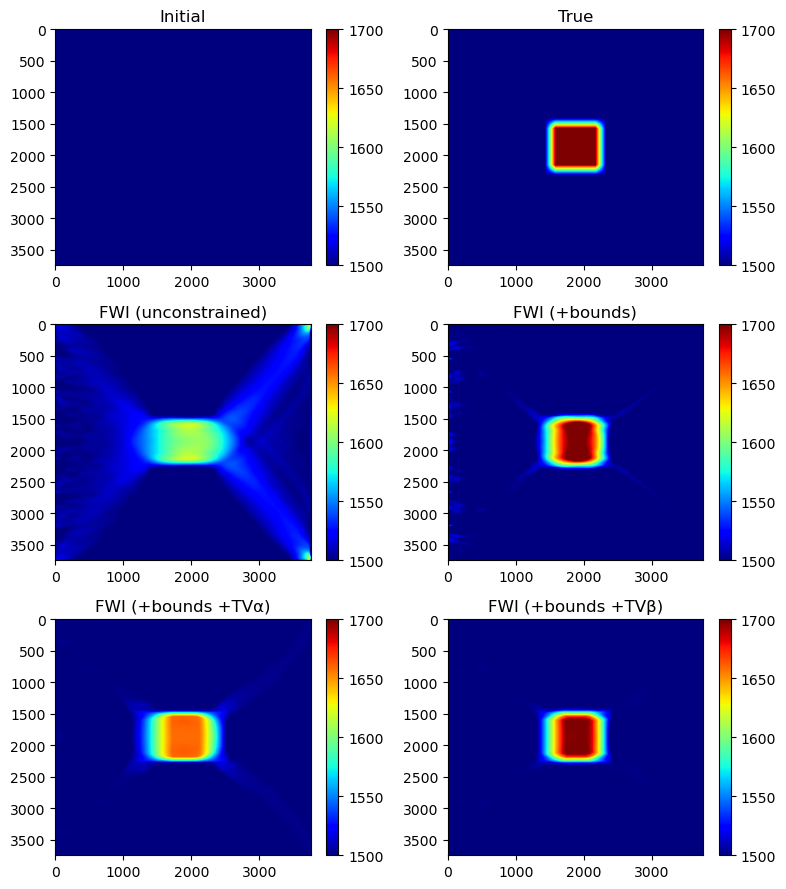

In [43]:
m   = reshape(m,nz,nx)
m0  = reshape(m0,nz,nx)

figure(figsize=(8,9)); clf()

subplot(3,2,1);imshow(m0,aspect="auto",cmap="jet",extent=extent);
colorbar(orientation="vertical");clim(vmin,vmax);title("Initial");

subplot(3,2,2);imshow(m,aspect="auto",cmap="jet",extent=extent);
colorbar(orientation="vertical");clim(vmin,vmax);title("True")

subplot(3,2,3);imshow(mf0,aspect="auto",cmap="jet",extent=extent);
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI (unconstrained)");

subplot(3,2,4);imshow(mf1,aspect="auto",cmap="jet",extent=extent);
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI (+bounds)");

subplot(3,2,5);imshow(mf2,aspect="auto",cmap="jet",extent=extent);
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI (+bounds +TVα)");

subplot(3,2,6);imshow(mf3,aspect="auto",cmap="jet",extent=extent);
colorbar(orientation="vertical");clim(vmin,vmax);title("FWI (+bounds +TVβ)");

tight_layout()

#### Display the velocity difference models 

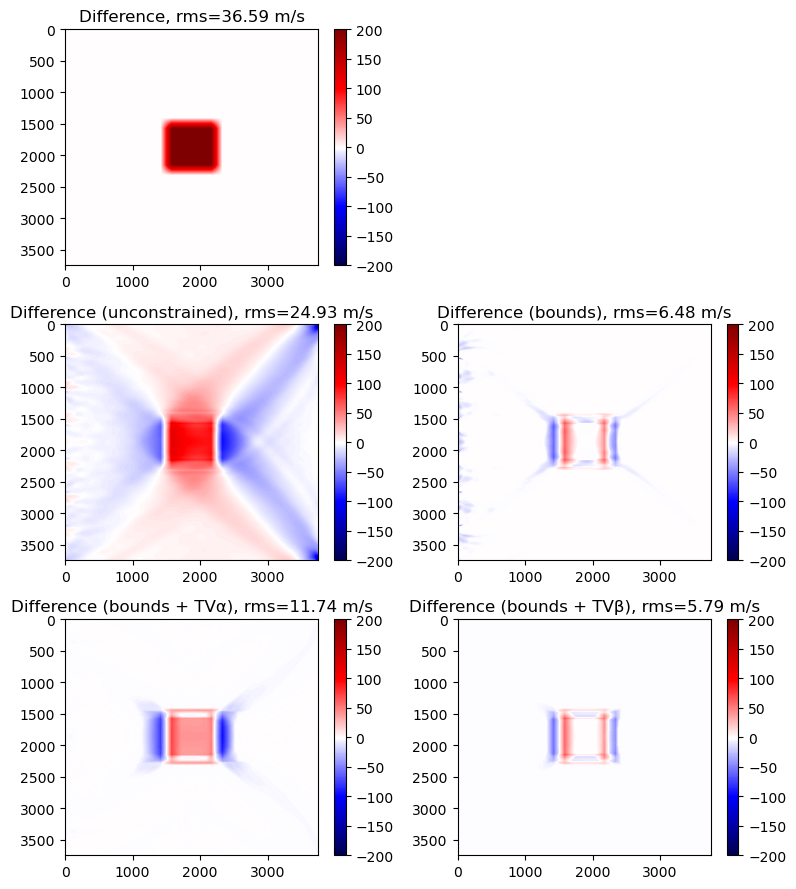

In [44]:
rms_v0  = @sprintf("%.2f m/s", sqrt(norm(m .- m0)^2 / length(m)))
rms_vf0 = @sprintf("%.2f m/s", sqrt(norm(m .- mf0)^2 / length(m)))
rms_vf1 = @sprintf("%.2f m/s", sqrt(norm(m .- mf1)^2 / length(m)))
rms_vf2 = @sprintf("%.2f m/s", sqrt(norm(m .- mf2)^2 / length(m)))
rms_vf3 = @sprintf("%.2f m/s", sqrt(norm(m .- mf3)^2 / length(m)))

figure(figsize=(8,9)); clf()

subplot(3,2,1);imshow(m .- m0,aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(dmin,dmax);
title("Difference, rms=$(rms_v0)");

subplot(3,2,3);imshow(m .- mf0,aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(dmin,dmax);
title("Difference (unconstrained), rms=$(rms_vf0)");

subplot(3,2,4);imshow(m .- mf1,aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(dmin,dmax);
title("Difference (bounds), rms=$(rms_vf1)");

subplot(3,2,5);imshow(m .- mf2,aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(dmin,dmax);
title("Difference (bounds + TVα), rms=$(rms_vf2)");

subplot(3,2,6);imshow(m .- mf3,aspect="auto",cmap="seismic",extent=extent);
colorbar(orientation="vertical");clim(dmin,dmax);
title("Difference (bounds + TVβ), rms=$(rms_vf3)");

tight_layout()

#### Generate data in the FWI models

In [45]:
tf0 = @elapsed begin
    df0 = F * reshape(mf0, domain(F));
end
@show tf0;
print("norm(d .- d0);  ", 0.5*norm(d .- d0)^2, "\n")
print("norm(d .- df0); ", 0.5*norm(d .- df0)^2, "\n\n")

tf1 = @elapsed begin
    df1 = F * reshape(mf1, domain(F));
end
@show tf1;
print("norm(d .- d0);  ", 0.5*norm(d .- d0)^2, "\n")
print("norm(d .- df1); ", 0.5*norm(d .- df1)^2, "\n\n")

tf2 = @elapsed begin
    df2 = F * reshape(mf2, domain(F));
end
@show tf2;
print("norm(d .- d0);  ", 0.5*norm(d .- d0)^2, "\n")
print("norm(d .- df2); ", 0.5*norm(d .- df2)^2, "\n\n")

tf3 = @elapsed begin
    df3 = F * reshape(mf3, domain(F));
end
@show tf3;
print("norm(d .- d0);  ", 0.5*norm(d .- d0)^2, "\n")
print("norm(d .- df3); ", 0.5*norm(d .- df3)^2, "\n\n")

tf0 = 12.290010919
norm(d .- d0);  102523.2265625
norm(d .- df0); 12.318838119506836

tf1 = 12.694897706
norm(d .- d0);  102523.2265625
norm(d .- df1); 19.360218048095703

tf2 = 12.899838889
norm(d .- d0);  102523.2265625
norm(d .- df2); 327.6198425292969

tf3 = 13.103433991
norm(d .- d0);  102523.2265625
norm(d .- df3); 17.127607345581055



#### Display the cost function 

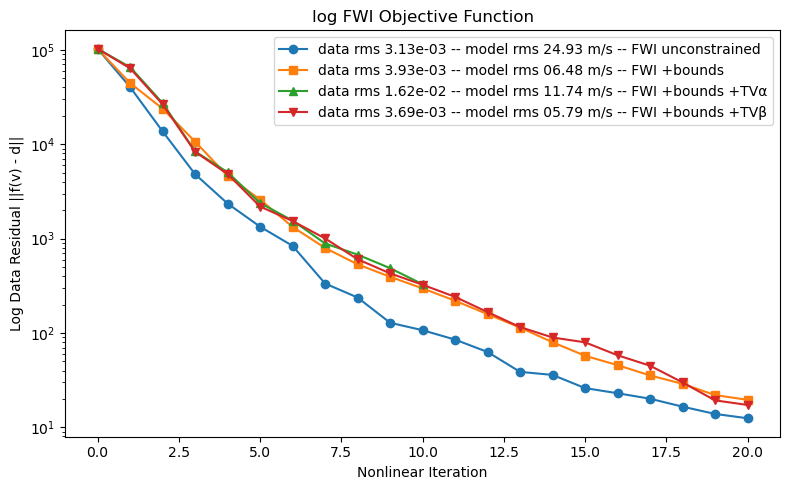

In [46]:
mrms0 = sqrt(norm(reshape(m_0[end],nz,nx) .- m)^2 / length(m))
mrms1 = sqrt(norm(reshape(m_1[end],nz,nx) .- m)^2 / length(m))
mrms2 = sqrt(norm(reshape(m_2[end],nz,nx) .- m)^2 / length(m))
mrms3 = sqrt(norm(reshape(m_3[end],nz,nx) .- m)^2 / length(m))

drms0 = sqrt(norm(df0 .- d)^2 / length(d))
drms1 = sqrt(norm(df1 .- d)^2 / length(d))
drms2 = sqrt(norm(df2 .- d)^2 / length(d))
drms3 = sqrt(norm(df3 .- d)^2 / length(d))

figure(figsize=(8,5)); clf()
plot(ϕ_0, marker="o", label=@sprintf("data rms %.2e -- model rms %05.2f m/s -- FWI unconstrained", drms0, mrms0))
plot(ϕ_1, marker="s", label=@sprintf("data rms %.2e -- model rms %05.2f m/s -- FWI +bounds",       drms1, mrms1))
plot(ϕ_2, marker="^", label=@sprintf("data rms %.2e -- model rms %05.2f m/s -- FWI +bounds +TVα",  drms2, mrms2))
plot(ϕ_3, marker="v", label=@sprintf("data rms %.2e -- model rms %05.2f m/s -- FWI +bounds +TVβ",  drms3, mrms3))
yscale("log")
xlabel("Nonlinear Iteration")
ylabel("Log Data Residual ||f(v) - d||")
legend()
title("log FWI Objective Function")
tight_layout()

#### Display data misfit vs model misfit

**Comments** 
- The addition of even very simple simple bound constraints gives a very significant improvement of FWI convergence.
- The successful use of total variation constraints requires careful selection of the threshold parameter, consider how different the two TV results are.
- We have brought additional information to bear on the problem; the COFII framework and Julia ecosystem allow easy incorporation of multiple types of additional information.

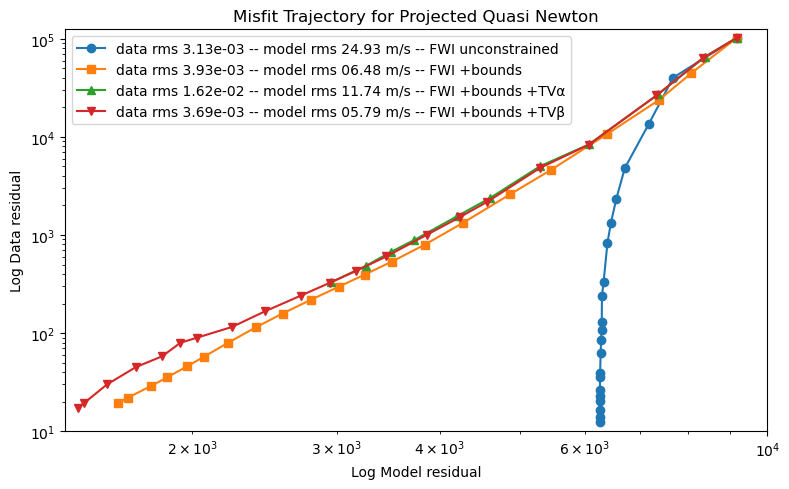

extrema(cat(c0, c1, c2, c3; dims = 1)) = (1452.4332f0, 9184.611f0)
extrema(cat(ϕ_0, ϕ_1, ϕ_2, ϕ_3; dims = 1)) = (12.477701f0, 102520.91f0)


In [47]:
figure(figsize=(8,5)); clf()

c0 = [norm(reshape(m_0[i],nz,nx) .- m, 2) for i in 1:length(m_0)]
c1 = [norm(reshape(m_1[i],nz,nx) .- m, 2) for i in 1:length(m_1)]
c2 = [norm(reshape(m_2[i],nz,nx) .- m, 2) for i in 1:length(m_2)]
c3 = [norm(reshape(m_3[i],nz,nx) .- m, 2) for i in 1:length(m_3)]

figure(figsize=(8,5)); clf()
loglog(c0, ϕ_0, marker="o", label=@sprintf("data rms %.2e -- model rms %05.2f m/s -- FWI unconstrained", drms0, mrms0))
loglog(c1, ϕ_1, marker="s", label=@sprintf("data rms %.2e -- model rms %05.2f m/s -- FWI +bounds",       drms1, mrms1))
loglog(c2, ϕ_2, marker="^", label=@sprintf("data rms %.2e -- model rms %05.2f m/s -- FWI +bounds +TVα",  drms2, mrms2))
loglog(c3, ϕ_3, marker="v", label=@sprintf("data rms %.2e -- model rms %05.2f m/s -- FWI +bounds +TVβ",  drms3, mrms3))
@show extrema(cat(c0,c1,c2,c3; dims=1))
@show extrema(cat(ϕ_0,ϕ_1,ϕ_2,ϕ_3; dims=1))
xlim([1400, 10000])
ylim([10, 125000])
legend()
xlabel("Log Model residual")
ylabel("Log Data residual")
title("Misfit Trajectory for Projected Quasi Newton");
tight_layout()

## 12. Visualize data match

#### Compute residuals

In [48]:
r0  = d0 .- d;
rf0 = df0 .- d;
rf1 = df1 .- d;
rf2 = df2 .- d;
rf3 = df3 .- d;

#### Plot shot gathers for true, initial model, and fwi models

The table below describes the data images below. We will flip the direction of the residual and modeled data in order to help display the match with the true data. We include the initial data as shown above for easier comparison. 

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial<br>Data (flipped)</b></td>
</tr>

<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (unconstrained)<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (unconstrained)<br>Data (flipped)</b></td>
</tr>

<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (+bounds)<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (+bounds)<br>Data (flipped)</b></td>
</tr>

<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (+bounds + TVα)<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (+bounds + TVα)<br>Data (flipped)</b></td>
</tr>

<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (+bounds + TVβ)<br>Residual Data (flipped)</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI (+bounds + TVβ)<br>Data (flipped)</b></td>
</tr>
</table>

We first make a function to create the plots that we can re-use for the selected shots.

In [49]:
zsrc = trunc.(zsrc; digits=6)

function make_plot(index)
    figure(figsize=(8,15)); clf()
    
    d_i   = getblock(d,index)
    d0_i  = getblock(d0,index)
    r0_i  = getblock(r0,index)

    df0_i = getblock(df0,index)
    df1_i = getblock(df1,index)
    df2_i = getblock(df2,index)
    df3_i = getblock(df3,index)

    rf0_i = getblock(rf0,index)
    rf1_i = getblock(rf1,index)
    rf2_i = getblock(rf2,index)
    rf3_i = getblock(rf3,index)

    cat0  = hcat(10 .* reverse(r0_i,dims=2), pad,  d_i, pad, reverse(d0_i,dims=2))
    catf0 = hcat(10 .* reverse(rf0_i,dims=2), pad, d_i, pad, reverse(df0_i,dims=2))
    catf1 = hcat(10 .* reverse(rf1_i,dims=2), pad, d_i, pad, reverse(df1_i,dims=2))
    catf2 = hcat(10 .* reverse(rf2_i,dims=2), pad, d_i, pad, reverse(df2_i,dims=2))
    catf3 = hcat(10 .* reverse(rf3_i,dims=2), pad, d_i, pad, reverse(df3_i,dims=2))

    subplot(5,1,1); imshow(1.5 .* cat0, cmap="gray",aspect="auto",clim=[-1,+1]); ylim(1101,500); title("Initial sz=$(zsrc[index])");
    subplot(5,1,2); imshow(1.5 .* catf0,cmap="gray",aspect="auto",clim=[-1,+1]); ylim(1101,500); title("FWI (unconstrained) sz=$(zsrc[index])");
    subplot(5,1,3); imshow(1.5 .* catf1,cmap="gray",aspect="auto",clim=[-1,+1]); ylim(1101,500); title("FWI (+bounds) sz=$(zsrc[index])");
    subplot(5,1,4); imshow(1.5 .* catf2,cmap="gray",aspect="auto",clim=[-1,+1]); ylim(1101,500); title("FWI (+bounds +TVα) sz=$(zsrc[index])");
    subplot(5,1,5); imshow(1.5 .* catf3,cmap="gray",aspect="auto",clim=[-1,+1]); ylim(1101,500); title("FWI (+bounds +TVβ) sz=$(zsrc[index])");

    suptitle("10x Residual | True | Modeled (flipped)\n")
    
    tight_layout()
end

make_plot (generic function with 1 method)

#### Data for the 1st shot, generated in the initial and FWI models

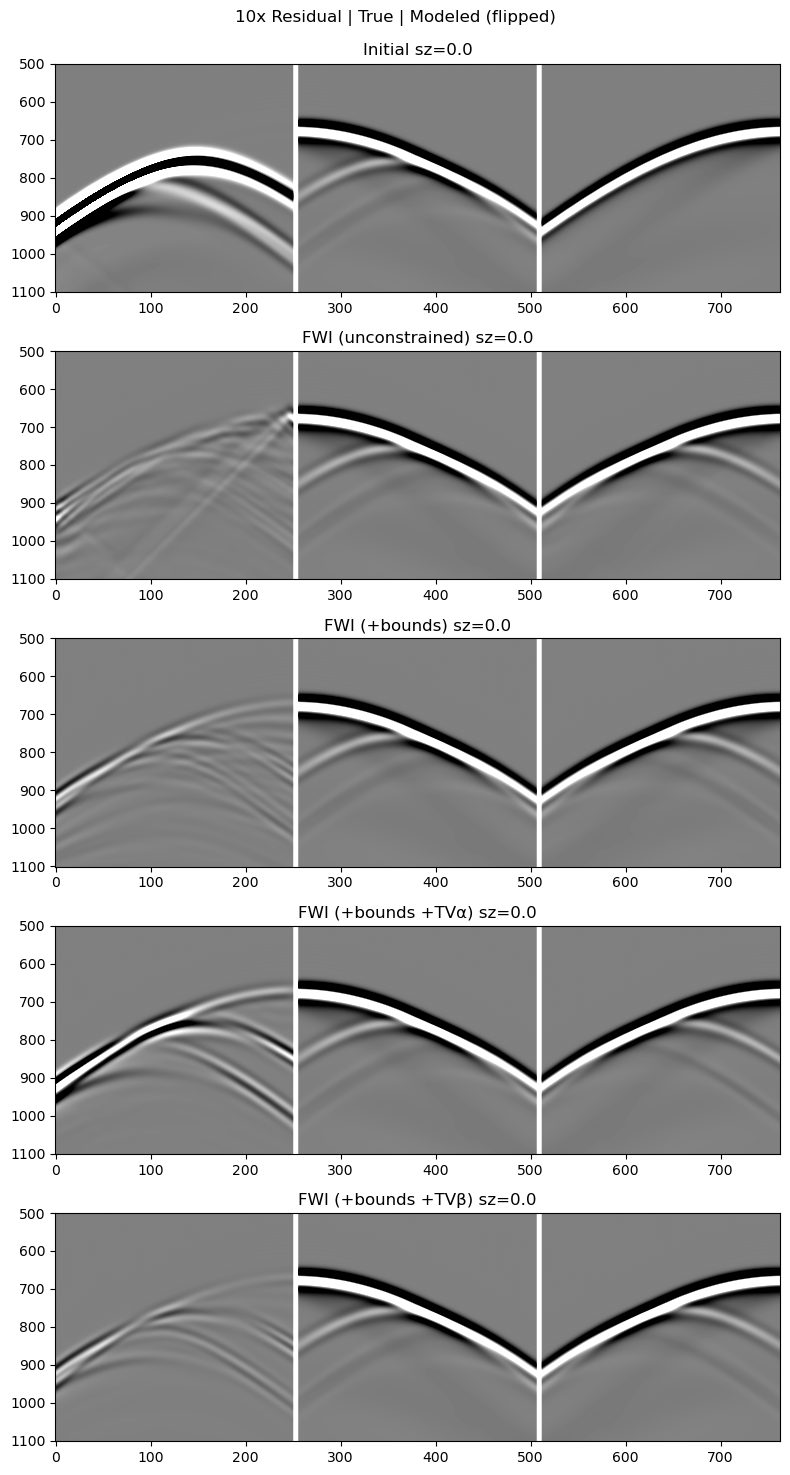

In [50]:
make_plot(1)

#### Data for the 4th shot, generated in the initial and FWI models

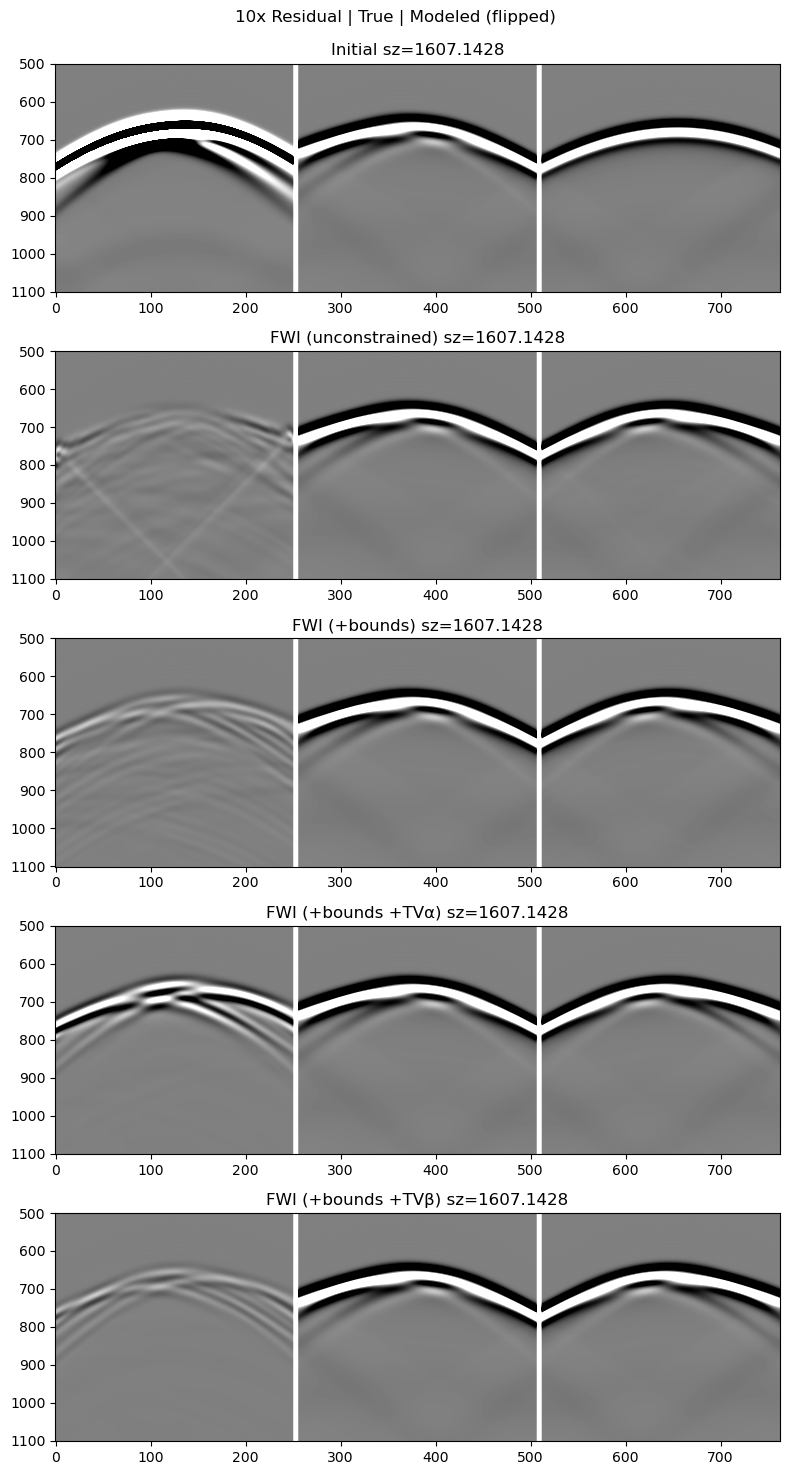

In [51]:
make_plot(4)

#### Data for the 8th shot, generated in the initial and FWI models

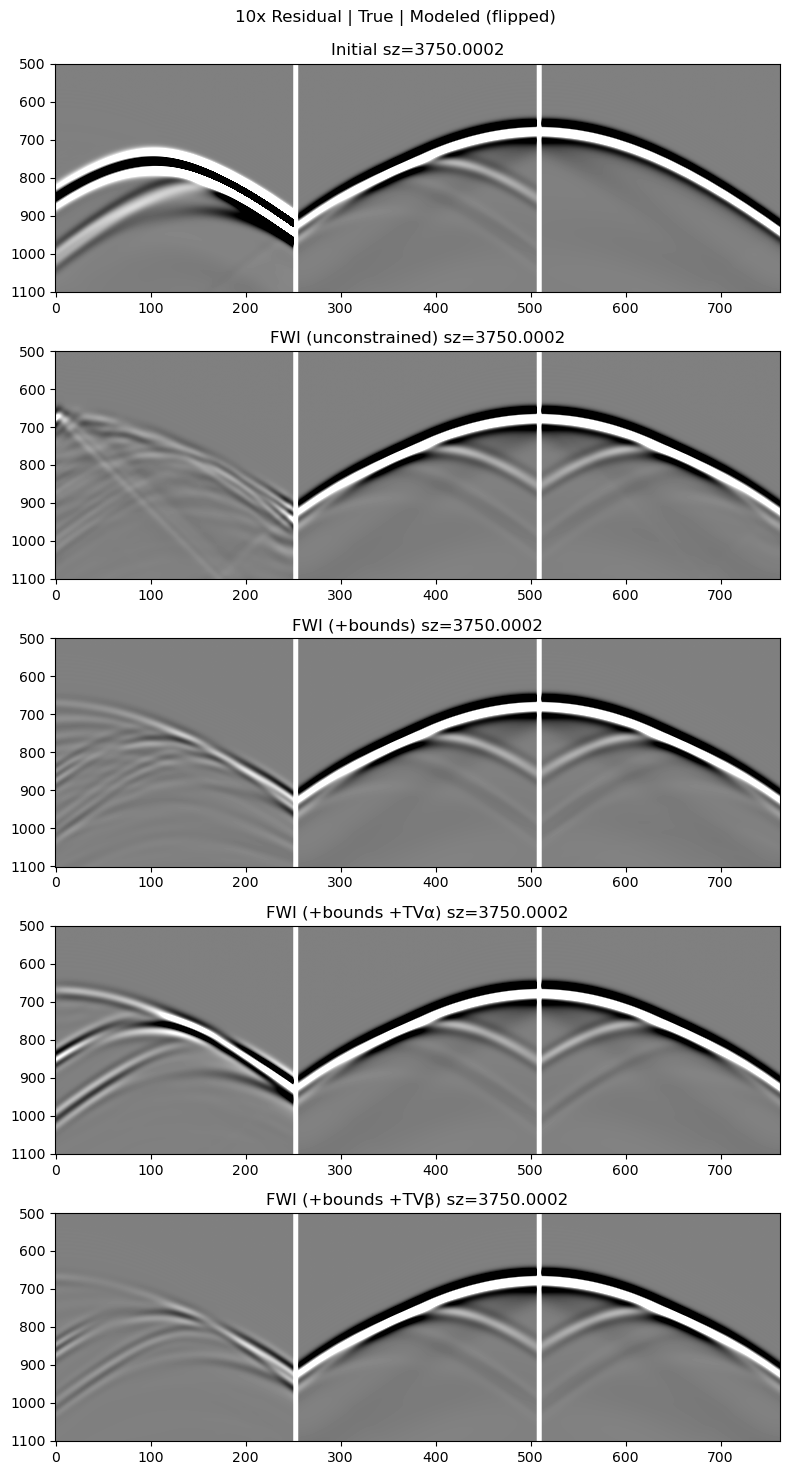

In [52]:
make_plot(8)

## 14. Remove workers <a id='del'></a>

In [53]:
rmprocs(workers());